In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)


np.random.seed(42)

### **Task 1**

=== TASK 1: MANUAL LDA IMPLEMENTATION ===
Dataset X:
[[1 3]
 [2 2]
 [3 1]
 [4 4]
 [5 5]
 [6 6]]
Labels y:
[0 0 0 1 1 1]
Mean of class 0: [2. 2.]
Mean of class 1: [5. 5.]
Within-class scatter matrix Sw:
[[4. 0.]
 [0. 4.]]

Optimal weight vector w: [-0.75 -0.75]
Threshold: -5.2500


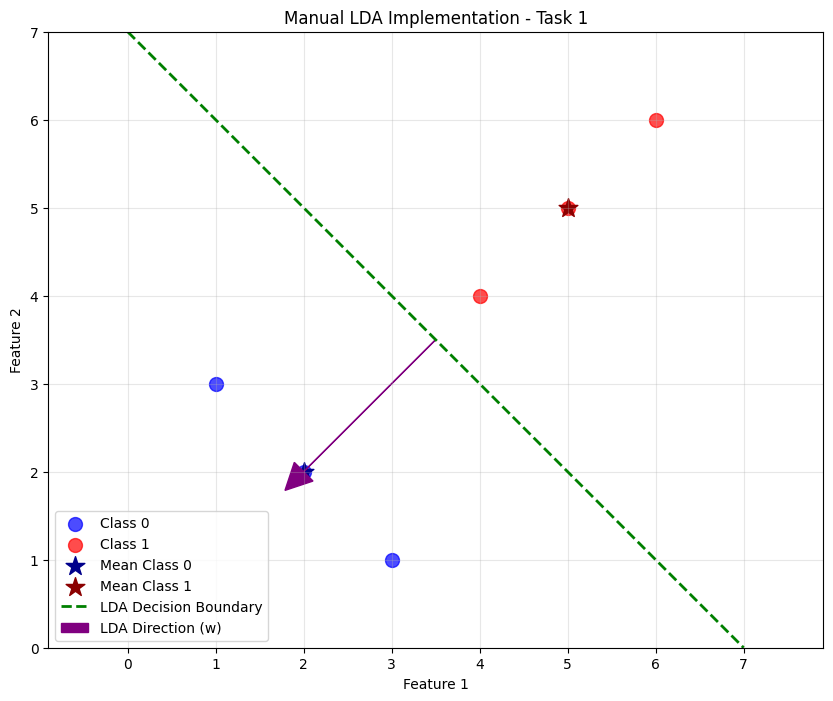

Classification accuracy: 0.0000


In [10]:
# Task 1a
X = np.array([[1,3],[2,2],[3,1],[4,4],[5,5],[6,6]])
y = np.array([0, 0, 0, 1, 1, 1])

print("Dataset X:")
print(X)
print("Labels y:")
print(y)

# Task 1b
def manual_lda(X, y):
    class0 = X[y == 0]
    class1 = X[y == 1]

    mu0 = np.mean(class0, axis=0)
    mu1 = np.mean(class1, axis=0)

    print(f"Mean of class 0: {mu0}")
    print(f"Mean of class 1: {mu1}")

    Sw = np.zeros((X.shape[1], X.shape[1]))

    for sample in class0:
        diff = (sample - mu0).reshape(-1, 1)
        Sw += np.dot(diff, diff.T)

    for sample in class1:
        diff = (sample - mu1).reshape(-1, 1)
        Sw += np.dot(diff, diff.T)

    print(f"Within-class scatter matrix Sw:\n{Sw}")

    Sw_inv = np.linalg.inv(Sw)
    w = np.dot(Sw_inv, (mu0 - mu1))

    proj_mu0 = np.dot(w.T, mu0)
    proj_mu1 = np.dot(w.T, mu1)
    threshold = (proj_mu0 + proj_mu1) / 2

    return w, threshold, mu0, mu1, Sw

w, threshold, mu0, mu1, Sw = manual_lda(X, y)

print(f"\nOptimal weight vector w: {w}")
print(f"Threshold: {threshold:.4f}")

# Task 1c
def plot_lda_results(X, y, w, threshold, mu0, mu1):
    plt.figure(figsize=(10, 8))

    plt.scatter(X[y==0, 0], X[y==0, 1], c='blue', label='Class 0', s=100, alpha=0.7)
    plt.scatter(X[y==1, 0], X[y==1, 1], c='red', label='Class 1', s=100, alpha=0.7)

    plt.scatter(mu0[0], mu0[1], c='darkblue', marker='*', s=200, label='Mean Class 0')
    plt.scatter(mu1[0], mu1[1], c='darkred', marker='*', s=200, label='Mean Class 1')

    x_vals = np.array([0, 7])
    y_vals = (-w[0] * x_vals + threshold) / w[1] if w[1] != 0 else np.zeros_like(x_vals)

    plt.plot(x_vals, y_vals, 'g--', linewidth=2, label='LDA Decision Boundary')

    scale = 2
    plt.arrow((mu0[0] + mu1[0])/2, (mu0[1] + mu1[1])/2,
              w[0]*scale, w[1]*scale,
              head_width=0.3, head_length=0.3, fc='purple', ec='purple',
              label='LDA Direction (w)')

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Manual LDA Implementation - Task 1')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.xlim(0, 7)
    plt.ylim(0, 7)
    plt.show()

    predictions = []
    for sample in X:
        projection = np.dot(w.T, sample)
        pred = 0 if projection < threshold else 1
        predictions.append(pred)

    accuracy = np.mean(np.array(predictions) == y)
    print(f"Classification accuracy: {accuracy:.4f}")

plot_lda_results(X, y, w, threshold, mu0, mu1)

### **Task 2**

Dataset shape: (40, 2)
Class distribution:
Class 0: 20 samples
Class 1: 20 samples
Class 0 mean: [-0.31515584  0.16976345]
Class 1 mean: [0.7577687 1.8981775]

Custom LDA Results:
Weight vector w: [-0.691834, -0.722057]
Threshold: -0.899693


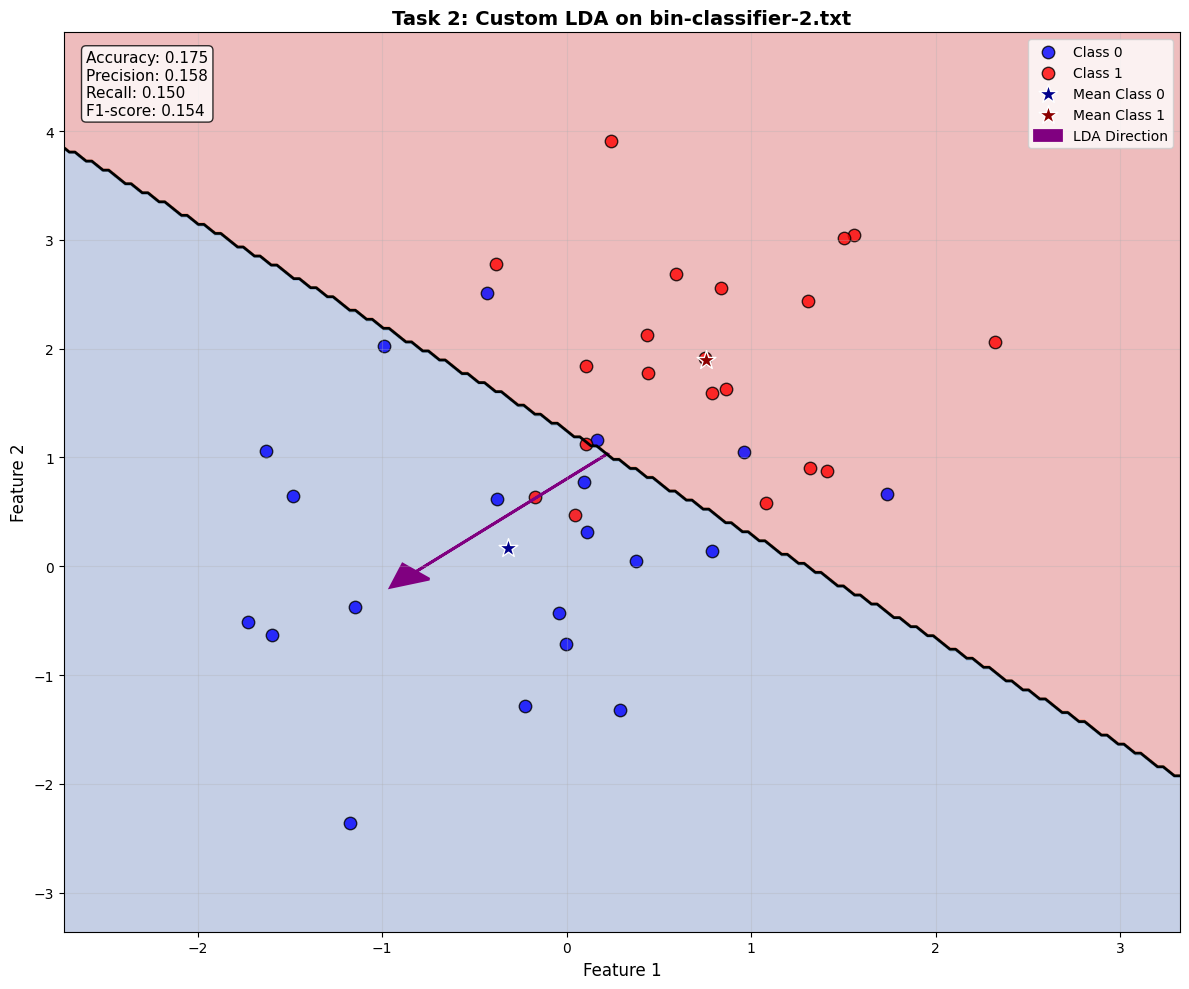


Custom LDA Performance on bin-classifier-2.txt:
Accuracy:  0.1750
Precision: 0.1579
Recall:    0.1500
F1-score:  0.1538


In [11]:

data = pd.read_csv('bin-classifier-2.txt', header=None)
X_bin = data.values[:, 0:2]
y_bin = data.values[:, 2]

print("Dataset shape:", X_bin.shape)
print("Class distribution:")
print(f"Class 0: {np.sum(y_bin == 0)} samples")
print(f"Class 1: {np.sum(y_bin == 1)} samples")

def robust_custom_lda(X, y):
    class0_data = X[y == 0]
    class1_data = X[y == 1]

    mu0 = np.mean(class0_data, axis=0)
    mu1 = np.mean(class1_data, axis=0)

    print(f"Class 0 mean: {mu0}")
    print(f"Class 1 mean: {mu1}")

    Sw = np.zeros((X.shape[1], X.shape[1]))

    regularization = 1e-6 * np.eye(X.shape[1])

    for sample in class0_data:
        deviation = sample - mu0
        Sw += np.outer(deviation, deviation)

    for sample in class1_data:
        deviation = sample - mu1
        Sw += np.outer(deviation, deviation)

    Sw += regularization

    try:
        Sw_inv = np.linalg.inv(Sw)
        w = np.dot(Sw_inv, (mu0 - mu1))
        w = w / np.linalg.norm(w)
    except np.linalg.LinAlgError:
        print("Sw matrix is singular, using pseudo-inverse")
        Sw_inv = np.linalg.pinv(Sw)
        w = np.dot(Sw_inv, (mu0 - mu1))
        w = w / np.linalg.norm(w)

    proj_mu0 = np.dot(w, mu0)
    proj_mu1 = np.dot(w, mu1)
    threshold = (proj_mu0 + proj_mu1) / 2

    print(f"\nCustom LDA Results:")
    print(f"Weight vector w: [{w[0]:.6f}, {w[1]:.6f}]")
    print(f"Threshold: {threshold:.6f}")

    return w, threshold, mu0, mu1

w_custom, threshold_custom, mu0_bin, mu1_bin = robust_custom_lda(X_bin, y_bin)

def plot_bin_classifier_results(X, y, w, threshold, mu0, mu1):
    plt.figure(figsize=(12, 10))

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))

    grid_points = np.c_[xx.ravel(), yy.ravel()]
    projections = np.dot(grid_points, w)
    Z = (projections > threshold).astype(int)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)
    plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)

    plt.scatter(X[y==0, 0], X[y==0, 1], c='blue', label='Class 0',
                s=80, alpha=0.8, edgecolors='black')
    plt.scatter(X[y==1, 0], X[y==1, 1], c='red', label='Class 1',
                s=80, alpha=0.8, edgecolors='black')

    plt.scatter(mu0[0], mu0[1], c='darkblue', marker='*', s=200,
                label='Mean Class 0', edgecolors='white')
    plt.scatter(mu1[0], mu1[1], c='darkred', marker='*', s=200,
                label='Mean Class 1', edgecolors='white')

    center = np.mean(X, axis=0)
    scale = 1.5
    plt.arrow(center[0], center[1], w[0]*scale, w[1]*scale,
              head_width=0.2, head_length=0.2, fc='purple', ec='purple',
              linewidth=2, label='LDA Direction')

    plt.xlabel('Feature 1', fontsize=12)
    plt.ylabel('Feature 2', fontsize=12)
    plt.title('Task 2: Custom LDA on bin-classifier-2.txt', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    predictions = (np.dot(X, w) > threshold).astype(int)
    accuracy = accuracy_score(y, predictions)
    precision = precision_score(y, predictions)
    recall = recall_score(y, predictions)
    f1 = f1_score(y, predictions)

    stats_text = f'Accuracy: {accuracy:.3f}\nPrecision: {precision:.3f}\nRecall: {recall:.3f}\nF1-score: {f1:.3f}'
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, fontsize=11,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

    return accuracy, precision, recall, f1

acc_bin, prec_bin, rec_bin, f1_bin = plot_bin_classifier_results(X_bin, y_bin,
                                                                w_custom, threshold_custom,
                                                                mu0_bin, mu1_bin)

print(f"\nCustom LDA Performance on bin-classifier-2.txt:")
print(f"Accuracy:  {acc_bin:.4f}")
print(f"Precision: {prec_bin:.4f}")
print(f"Recall:    {rec_bin:.4f}")
print(f"F1-score:  {f1_bin:.4f}")

### **Task 3**

sklearn LDA Results:
Accuracy:  0.7500
Precision: 0.7143
Recall:    0.8333
F1-score:  0.7692
5-fold CV F1-scores: [0.88888889 1.         0.85714286 0.6        0.88888889]
Mean CV F1-score: 0.8470 (+/- 0.2654)

Optimized Logistic Regression Results:
Best parameters: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy:  0.7500
Precision: 0.7143
Recall:    0.8333
F1-score:  0.7692

MODEL COMPARISON AND BEST MODEL SELECTION
LDA F1-score: 0.7692
Logistic Regression F1-score: 0.7692

🎯 BEST MODEL: LDA (F1-score: 0.7692)


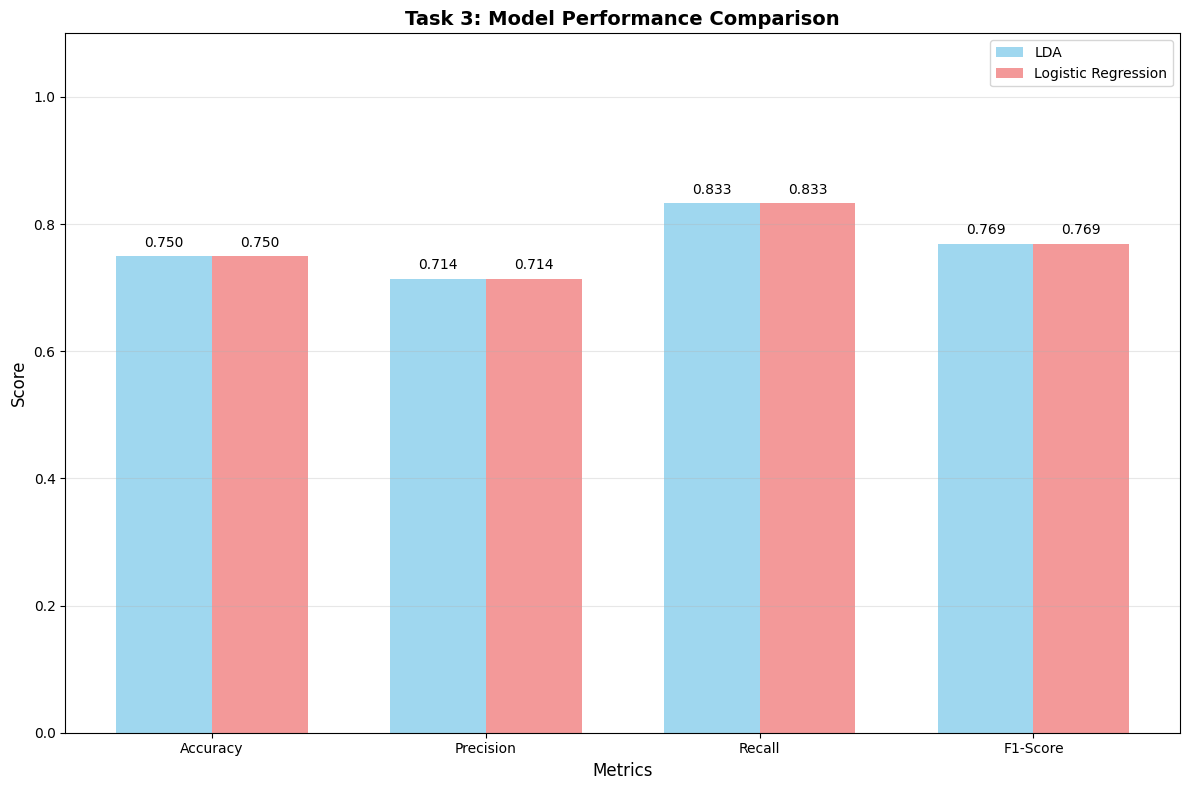

In [14]:
# Task 3a
def evaluate_sklearn_lda(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                        random_state=42, stratify=y)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train_scaled, y_train)

    y_pred_lda = lda.predict(X_test_scaled)
    y_pred_proba_lda = lda.predict_proba(X_test_scaled)[:, 1]

    accuracy_lda = accuracy_score(y_test, y_pred_lda)
    precision_lda = precision_score(y_test, y_pred_lda)
    recall_lda = recall_score(y_test, y_pred_lda)
    f1_lda = f1_score(y_test, y_pred_lda)

    print("sklearn LDA Results:")
    print(f"Accuracy:  {accuracy_lda:.4f}")
    print(f"Precision: {precision_lda:.4f}")
    print(f"Recall:    {recall_lda:.4f}")
    print(f"F1-score:  {f1_lda:.4f}")

    cv_scores = cross_val_score(lda, scaler.fit_transform(X), y, cv=5, scoring='f1')
    print(f"5-fold CV F1-scores: {cv_scores}")
    print(f"Mean CV F1-score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    return lda, scaler, accuracy_lda, precision_lda, recall_lda, f1_lda

lda_model, scaler, acc_lda, prec_lda, rec_lda, f1_lda = evaluate_sklearn_lda(X_bin, y_bin)

# Task 3b
def optimize_logistic_regression(X, y):
    """Optimize Logistic Regression using GridSearchCV"""

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                        random_state=42, stratify=y)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }

    lr = LogisticRegression(random_state=42, max_iter=1000)
    grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)

    best_lr = grid_search.best_estimator_
    y_pred_lr = best_lr.predict(X_test_scaled)

    accuracy_lr = accuracy_score(y_test, y_pred_lr)
    precision_lr = precision_score(y_test, y_pred_lr)
    recall_lr = recall_score(y_test, y_pred_lr)
    f1_lr = f1_score(y_test, y_pred_lr)

    print("\nOptimized Logistic Regression Results:")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Accuracy:  {accuracy_lr:.4f}")
    print(f"Precision: {precision_lr:.4f}")
    print(f"Recall:    {recall_lr:.4f}")
    print(f"F1-score:  {f1_lr:.4f}")

    cv_results = grid_search.cv_results_

    return best_lr, grid_search, accuracy_lr, precision_lr, recall_lr, f1_lr

best_lr_model, grid_search, acc_lr, prec_lr, rec_lr, f1_lr = optimize_logistic_regression(X_bin, y_bin)

# Task 3c
def compare_models(lda_f1, lr_f1, lda_model, lr_model, grid_search):
    print("\n" + "="*50)
    print("MODEL COMPARISON AND BEST MODEL SELECTION")
    print("="*50)

    models = {
        'LDA': lda_f1,
        'Logistic Regression': lr_f1
    }

    best_model_name = max(models, key=models.get)
    best_f1_score = models[best_model_name]

    print(f"LDA F1-score: {lda_f1:.4f}")
    print(f"Logistic Regression F1-score: {lr_f1:.4f}")
    print(f"\n🎯 BEST MODEL: {best_model_name} (F1-score: {best_f1_score:.4f})")

    if best_model_name == 'Logistic Regression':
        print(f"\nBest Hyperparameters:")
        for param, value in grid_search.best_params_.items():
            print(f"  {param}: {value}")

        cv_results = pd.DataFrame(grid_search.cv_results_)
        top_scores = cv_results.nlargest(5, 'mean_test_score')

        print(f"\nTop 5 CV configurations by F1-score:")
        for i, (idx, row) in enumerate(top_scores.iterrows()):
            print(f"{i+1}. Params: {row['params']} | Mean F1: {row['mean_test_score']:.4f}")

    return best_model_name, best_f1_score

best_model, best_f1 = compare_models(f1_lda, f1_lr, lda_model, best_lr_model, grid_search)

# Final visualization: Model comparison plot
def plot_model_comparison(lda_metrics, lr_metrics):
    """Visual comparison of model performance"""

    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    lda_values = lda_metrics
    lr_values = lr_metrics

    x = np.arange(len(metrics))
    width = 0.35

    plt.figure(figsize=(12, 8))

    plt.bar(x - width/2, lda_values, width, label='LDA', alpha=0.8, color='skyblue')
    plt.bar(x + width/2, lr_values, width, label='Logistic Regression', alpha=0.8, color='lightcoral')

    plt.xlabel('Metrics', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title('Task 3: Model Performance Comparison', fontsize=14, fontweight='bold')
    plt.xticks(x, metrics)
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for i, v in enumerate(lda_values):
        plt.text(i - width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    for i, v in enumerate(lr_values):
        plt.text(i + width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

    plt.ylim(0, 1.1)
    plt.tight_layout()
    plt.show()

# Plot comparison
lda_metrics = [acc_lda, prec_lda, rec_lda, f1_lda]
lr_metrics = [acc_lr, prec_lr, rec_lr, f1_lr]
plot_model_comparison(lda_metrics, lr_metrics)